# Quiz

# Timings of Quizzes and Homeworks

# The One Goal For Today

Understand how normalization first helps or hinders PCA and linear regression models.

## Review



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import scipy.linalg as sp_la

### Load and Look at Your Data

Today I will keep working with the set of Craigslist listings for used cars. For the homework, you will work with your own data set!

This code below you can use as a **tool**.
* Change the columns to the columns for your data
* Change the tuple in "usecols" to the tuples for your data

First we make data converters for non-numeric variables.

In [2]:
# these will be our columns
columns = ["price", "year", "manufacturer", "model", "condition", "fuel", "odometer", "title_status", "transmission"]
# this will contain our converters
colValues = {}

# first we load our data as strings so we can define the converters
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), skip_header=1, dtype=str, encoding='utf-8'))  

# make a list of the unique values in each column of our data
for colIndex in range(data.shape[1]):
    colValues[colIndex] = np.unique(data[:, colIndex]).tolist()
    print(colIndex, colValues[colIndex])

# map values to their indices in the list of unique values
def converter(x, colIndex):
    return colValues[colIndex].index(x)

0 ['0', '1', '1000', '10000', '10199', '10200', '10300', '10399', '10400', '10450', '10475', '10488', '10491', '10494', '10495', '10498', '10500', '10550', '10600', '10650', '10691', '10695', '10700', '10800', '10844', '10888', '10900', '10950', '10977', '10980', '10988', '10989', '10990', '10995', '10999', '11000', '11011', '11200', '11250', '11272', '11375', '11380', '11450', '11480', '11493', '11495', '11499', '1150', '11500', '11515', '11550', '11600', '11700', '11795', '11900', '11901', '1195', '11950', '11976', '11985', '11987', '11988', '11990', '11995', '11997', '11999', '1200', '12000', '12177', '12250', '12400', '12450', '12488', '12495', '12499', '1250', '12500', '12588', '12595', '1275', '12775', '12835', '12875', '12889', '12900', '1295', '12950', '12977', '12990', '12995', '12999', '1300', '13000', '13299', '13300', '13325', '13400', '13440', '13450', '13488', '13490', '13494', '13495', '13500', '13599', '13600', '13650', '13750', '13753', '13795', '13850', '13860', '1388

Then we load the data.

In [3]:
data = np.array(np.genfromtxt('data/vehicles.csv', delimiter=',', usecols=(1,2,3,4,5,7,8,9,11), converters={3: lambda x: converter(x, 2), 4: lambda x: converter(x, 3), 5: lambda x: converter(x, 4), 7: lambda x: converter(x,5), 9: lambda x: converter(x, 7), 11: lambda x: converter(x, 8)}, skip_header=1, dtype=int, encoding='utf-8'))  

Then we get summary statistics and a pairplot of the independent variables vs the dependent variable.

In [4]:
def getSummaryStatistics(data):
    print("min, max, mean, std per variable")
    return pd.DataFrame([data.min(axis=0), data.max(axis=0), data.mean(axis=0), data.std(axis=0)])

def getShapeType(data):
    print("shape")
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

min, max, mean, std per variable
              0            1         2           3         4         5  \
0      0.000000  1999.000000  0.000000    0.000000  0.000000  0.000000   
1  55000.000000  2021.000000  1.000000  340.000000  5.000000  4.000000   
2   7978.281507  2012.381887  0.445535  159.225142  1.061431  2.012350   
3   5542.906703     3.997048  0.497025   96.160745  1.225660  0.138432   

              6         7         8  
0  0.000000e+00  0.000000  0.000000  
1  9.999999e+06  5.000000  2.000000  
2  1.124405e+05  0.209943  0.886954  
3  2.546163e+05  0.910812  0.424340  
shape
((3158, 9), dtype('int64'))


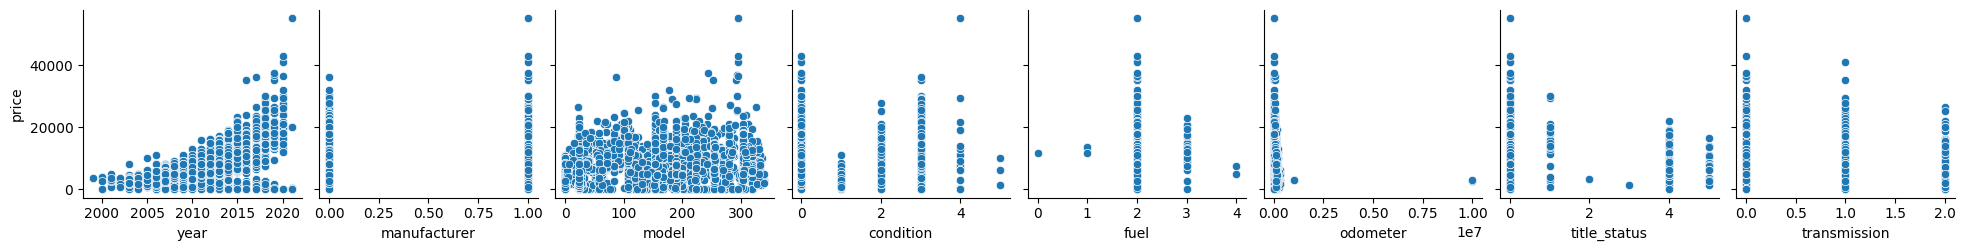

In [5]:
df = pd.DataFrame(data, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

plt.show()

### Normalize Your Data

Here we implement max-min global, max-min local, z-score and center, all in one function. If you see a bug, tell us!

This code you can use as a **tool**.

In [6]:
def normalize(data, method='center'):
    if method == 'center':
        return data - np.mean(data, axis=0)
    elif method == 'max-min-global':
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    elif method == 'max-min-local':
        return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))
    elif method == 'zscore':
        return (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    else:
        raise Exception("I can't do " + method)

Let's try it!

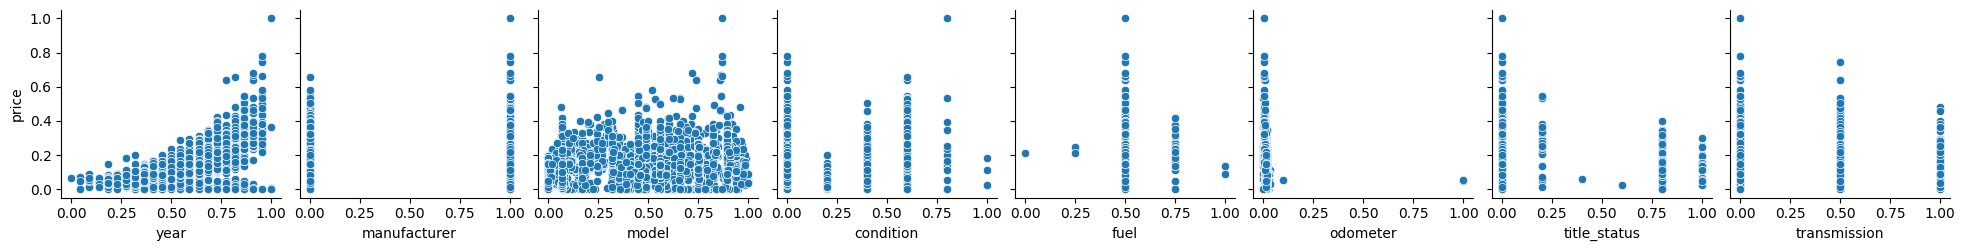

In [7]:
normalized_data = normalize(data, method='max-min-local')
df = pd.DataFrame(normalized_data, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

Once you have figured out which type of normalization to do, set data to the normalized data.

In [8]:
og_data = data
data = normalized_data


# Impact of Normalization on Regression

The code below will fit a linear or polynomial regression using the independent and dependent variables of your choice.

Let's split our data into **train** and **test**. 

This code you can use as a **tool**.
* I sort by the car data by time first. 
* You should figure out if you need to sort your data (or shuffle your data) first.

In [9]:
# if you need to shuffle your data
np.random.shuffle(data)
print(data[0:5])

# if you need to sort your data; I'm sorting by column 1, time
data = data[data[:, 1].argsort()]
print(data[0:5])

(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print(train.shape, test.shape)

[[0.32172727 0.86363636 0.         0.89411765 0.         0.5
  0.0031888  0.         0.        ]
 [0.31514545 0.81818182 0.         0.28823529 0.6        0.75
  0.0042149  0.         0.5       ]
 [0.12725455 0.68181818 0.         0.10588235 0.         0.5
  0.0161322  0.         0.5       ]
 [0.21809091 0.63636364 0.         0.09411765 0.         0.5
  0.0088454  0.         0.5       ]
 [0.13990909 0.45454545 0.         0.47058824 0.4        0.5
  0.0091442  0.         0.5       ]]
[[6.36363636e-02 0.00000000e+00 1.00000000e+00 8.29411765e-01
  0.00000000e+00 5.00000000e-01 1.37000014e-02 0.00000000e+00
  0.00000000e+00]
 [1.81818182e-05 4.54545455e-02 0.00000000e+00 7.05882353e-02
  4.00000000e-01 5.00000000e-01 1.50000015e-02 0.00000000e+00
  5.00000000e-01]
 [7.27090909e-02 4.54545455e-02 1.00000000e+00 8.23529412e-01
  0.00000000e+00 5.00000000e-01 7.85260079e-03 0.00000000e+00
  5.00000000e-01]
 [4.54363636e-02 4.54545455e-02 0.00000000e+00 5.88235294e-01
  6.00000000e-01 5.000000

This comes directly from last week.

In [10]:
# x an array of multiple independent variables
# poly -> polys, an array of multiple polynomial degrees for each column in x in order
def makePoly(x, polys):
    # make an empty array of size A
    A = np.zeros([x.shape[0], np.sum(polys)+1])
    # left most column of 1s for the intercept
    A[:, 0] = np.squeeze(x[:, 0]**0)
    k = 1
    for (j, poly) in enumerate(polys):
        for i in range(1, poly+1):
            A[:, k] = np.squeeze(x[:, j]**i)
            k += 1
    return A

def fit_lr(data, independent, dependent, polys):
    # These are our independent variables
    x = data[np.ix_(np.arange(data.shape[0]), independent)] 
    # This is the dependent variable 
    y = data[:, dependent]
    A = makePoly(x, polys)
    c, _, _, _ = sp_la.lstsq(A, y)
    return c

def predict_lr(data, independent, polys, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    A = makePoly(x, polys)
    return np.dot(A, c)

def msse(y, yhat):
    r = ((y - yhat)**2).mean()
    return r

def rsquared(y, yhat):
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

This next cell calculates a multiple linear regression on the data using all the independent variables.

**If your dependent variable is not at 0, modify this cell before running!**

In [11]:
independent = list(range(1, train.shape[1]))
polys = [1 for x in independent]
c = fit_lr(train, independent, 0, polys)
yhat_train = predict_lr(train, independent, polys, c)
yhat_test = predict_lr(test, independent, polys, c)
print(msse(train[:, 0], yhat_train), rsquared(test[:, 0], yhat_test))

0.003471174995896349 0.07207228650387543


And this next cell fits a polynomial regression using all the independent variables, with only the one at index 1 raised to the power 2.

In [12]:
independent = list(range(1, train.shape[1]))
polys = [1 for x in independent]
polys[0] = 2
c = fit_lr(train, independent, 0, polys)
yhat_train = predict_lr(train, independent, polys, c)
yhat_test = predict_lr(test, independent, polys, c)
print(msse(train[:, 0], yhat_train), rsquared(test[:, 0], yhat_test))

0.003422712808119826 0.12091336542632092


Try regression:
* without any data normalization
* with each method of data normalization

What works best?

# Impact of Normalization on PCA

The code below comes from this week. I just put it in functions. This code you can use as a **tool**.

In [13]:
def fit_pca(data):
    # center
    centered_data = data - np.mean(data, axis=0)
    # covariance matrix
    covariance_matrix = (centered_data.T @ centered_data) / (data.shape[0] - 1)
    # plot covariance matrix
    fig = plt.figure(figsize=(12,12))
    seaborn.heatmap(pd.DataFrame(covariance_matrix), annot=False, cmap='PuOr')
    plt.show()
    # eigenvalues and eigenvectors, sorted
    (evals, evectors) = np.linalg.eig(covariance_matrix)
    order = np.argsort(evals)[::-1]
    eigenvals_sorted = evals[order]
    eigenvecs_sorted = evectors[:, order]
    print(eigenvals_sorted.shape, eigenvecs_sorted.shape)
    return np.mean(data, axis=0), eigenvals_sorted, eigenvecs_sorted

def variances(eigenvals_sorted, eigenvecs_sorted):
    # calculate proportional variances and cumulative sum
    sum = np.sum(eigenvals_sorted)
    proportional_variances = np.array([eigenvalue / sum for eigenvalue in eigenvals_sorted])
    cumulative_sum = np.cumsum(proportional_variances)
    # scree plot
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(proportional_variances)), proportional_variances, alpha=0.5, align='center',
            label='Proportional variance')
    plt.ylabel('Proportional variance ratio')
    plt.xlabel('Ranked Principal Components')
    plt.title("Scree Graph")
    plt.legend(loc='best')
    plt.tight_layout()
    # elbow plot
    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)
    ax1.plot(cumulative_sum)
    ax1.set_ylim([0,1.0])
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Cumulative explained variance')
    ax1.set_title('Elbow Plot')
    plt.show()

def project_pca(data, mean, eigenvecs_sorted, to_keep):
    centered_data = data - mean
    return centered_data@eigenvecs_sorted[:, :to_keep]

def reconstruct_pca(projected_data):
    return projected_data@v.T + np.mean(data, axis=0)
    

Let's try it on our training data. 

**If you intend to fit a model (for example, linear regression) after transforming your data using PCA, you should fit the PCA using your training data only. Then, transform your training and test data using the eigenvalues and eigenvectors from your training data.**

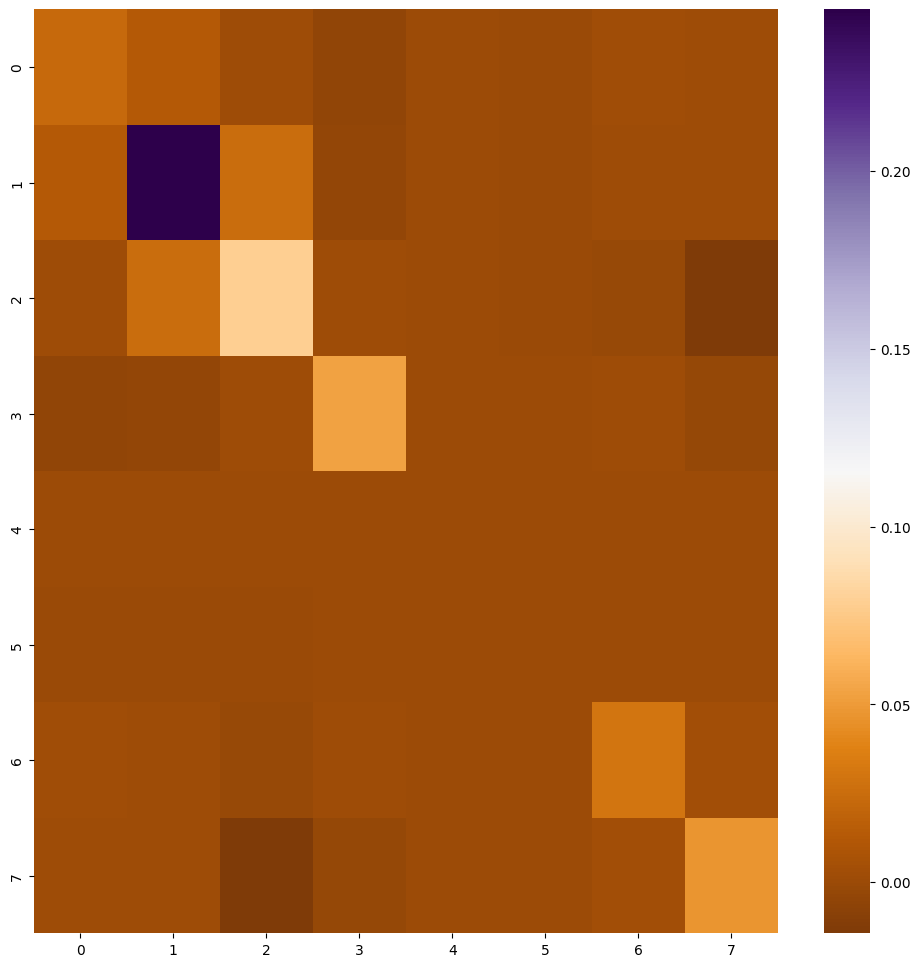

(8,) (8, 8)


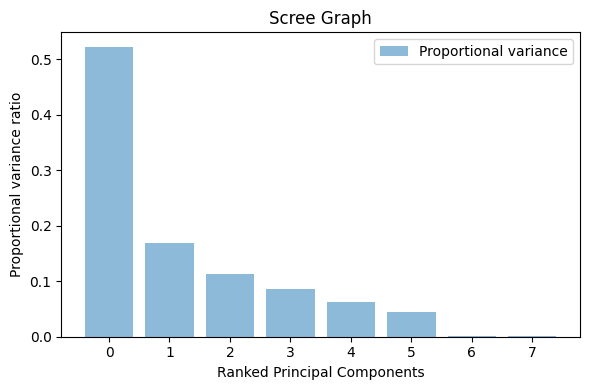

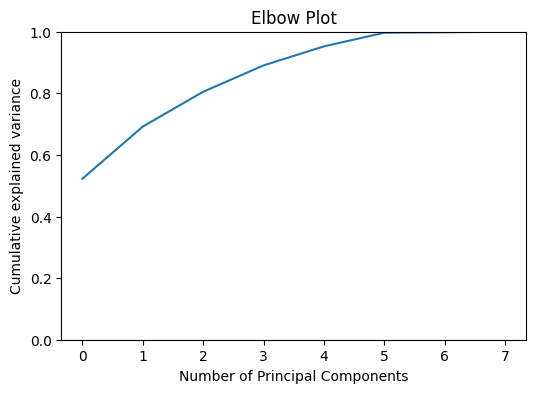

In [14]:
independent = list(range(1, train.shape[1]))
train_x = train[np.ix_(np.arange(train.shape[0]), independent)] 
# split off the dependent variable, which we don't want to include in the PCA model
train_y = train[:, 0]
test_x = test[np.ix_(np.arange(test.shape[0]), independent)] 
# split off the dependent variable, which we don't want to include in the PCA model
test_y = test[:, 0]

mean, eigenvals_sorted, eigenvecs_sorted = fit_pca(train_x)
variances(eigenvals_sorted, eigenvecs_sorted)

In [18]:
to_keep = 5
projected_train = project_pca(train_x, mean, eigenvecs_sorted, to_keep)
# stick the dependent variable back on!
projected_train = np.hstack((np.array([train_y]).T, projected_train))
print(train.shape, projected_train.shape)
projected_test = project_pca(test_x, mean, eigenvecs_sorted, to_keep)
# stick the dependent variable back on!
projected_test = np.hstack((np.array([test_y]).T, projected_test))
print(test.shape, projected_test.shape)

(2526, 9) (2526, 6)
(632, 9) (632, 6)


Try PCA:
* without any data normalization
* with each method of data normalization

Which works best?

# Compare Regression on Raw vs PCA Transformed Data

Now for your data set, compare the performance of regression on the raw data vs the (normalized and) PCA transformed data.

There's a lot to consider here, so I'd suggest keeping a log in the form of the table below.

| Normalization | PCA? | Independent variables | Polynomials | MSSE on Train | $R^2$ on Test | 
| ------------- | ---- | --------------------- | ----------- | ------------- | ------------- |
|     none      |   no |            all        |   all 1     |               |               |
| max-min-local |   keep 7 |        all        |   first principal component squared, rest 1    |               |               |

This next cell calculates a multiple linear regression on the data using all the independent variables.

**If your dependent variable is not at 0, modify this cell before running!**

In [19]:
independent = list(range(1, projected_train.shape[1]))
polys = [1 for x in independent]
c = fit_lr(projected_train, independent, 0, polys)
yhat_train = predict_lr(projected_train, independent, polys, c)
yhat_test = predict_lr(projected_test, independent, polys, c)
print(msse(train[:, 0], yhat_train), rsquared(test[:, 0], yhat_test))

0.004972750428423382 -0.44604120251080603


And this next cell fits a polynomial regression using all the independent variables, with only the one at index 1 raised to the power 2.

In [20]:
independent = list(range(1, projected_train.shape[1]))
polys = [1 for x in independent]
polys[0] = 2
c = fit_lr(projected_train, independent, 0, polys)
yhat_train = predict_lr(projected_train, independent, polys, c)
yhat_test = predict_lr(projected_test, independent, polys, c)
print(msse(train[:, 0], yhat_train), rsquared(test[:, 0], yhat_test))

0.004931900448084152 -0.45920842422565666
